# Advanced Lane Detection

In this notebook i describe an algorithm that can detect lane lines in a video taken by a dashboard camera.
In order to keep the notebook clean, most of the algorithm blokes are written and imported from camera_calibration.py and lane_find_funcs.py

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

from camera_calibration import calibrate_camera
from lane_find_funcs import color_and_grad_binary, set_percpective_transform, warp_image
from lane_find_funcs import curv_calc_sliding_window, curv_calc_from_previous
from lane_find_funcs import add_lines_to_img, measure_curvature_and_offset
%matplotlib inline

## Part 1 - Calibrate the camera
in order to compensate for camera distortions, we first calibrate it using a dataset of chess grid images

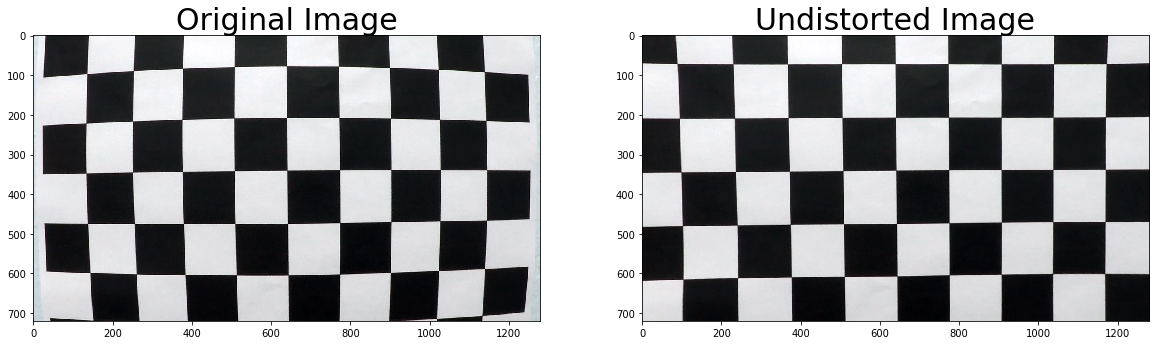

In [2]:
cal_values = calibrate_camera(draw_intermediate=True)

Text(0.5,1,'Undistorted Image')

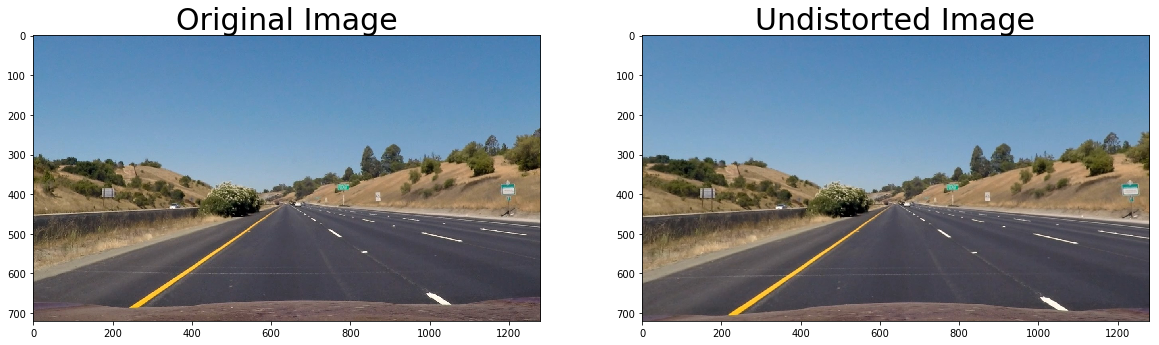

In [3]:
# we can use the calibration values to fix distortion on our images
img=cv2.imread('test_images/straight_lines1.jpg')
dst = cv2.undistort(img, cal_values['mtx'], cal_values['dist'], None, cal_values['mtx'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)


## Part 2 - Single Image Pipeline

In [4]:
# lets read the images
images = []
images_paths = glob.glob('test_images/*.jpg')
for path in images_paths:
    images.append(cv2.imread(path))
# for the visualization we will take one of the images
img = images[7]

In [5]:
# Step 1 undistort the image
dst = cv2.undistort(img, cal_values['mtx'], cal_values['dist'], None, cal_values['mtx'])

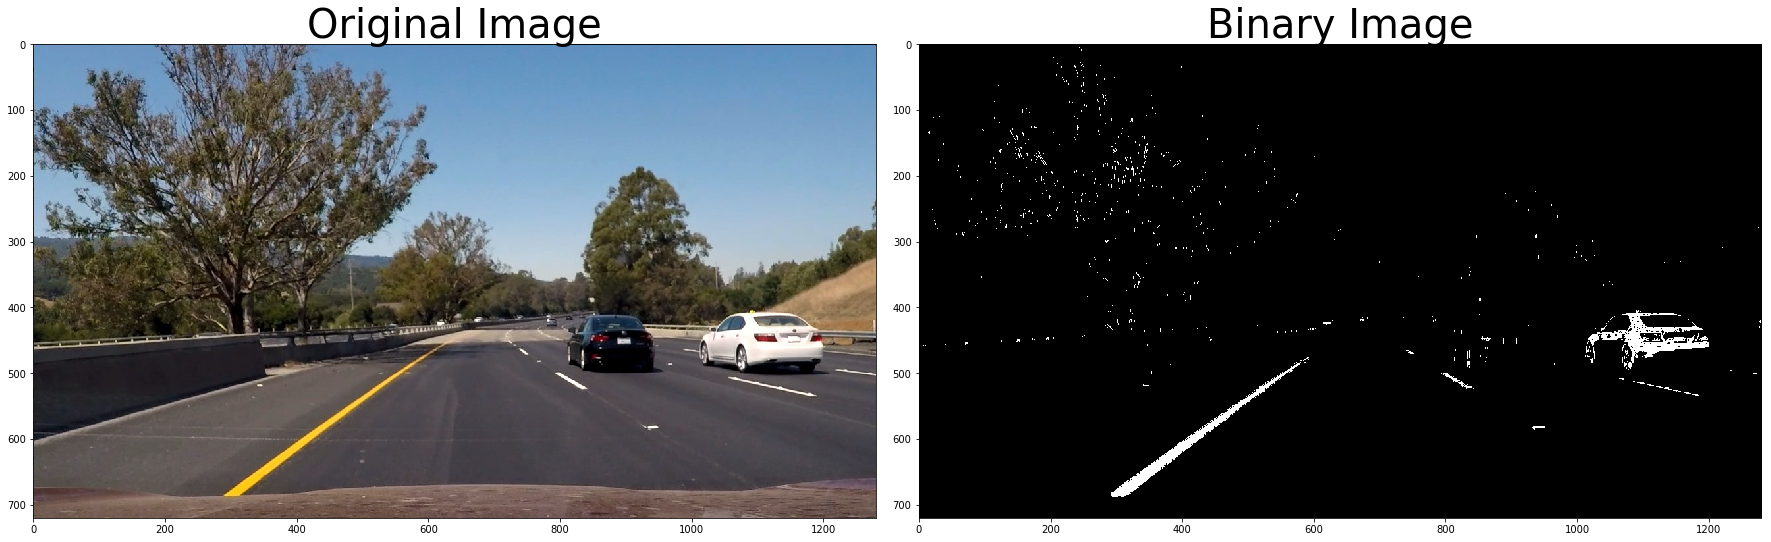

In [6]:
# Step 2 create a binary image.
binary = color_and_grad_binary(img, s_thresh=(150,255), l_thresh=(50,255), sx_thresh=(100,255), draw_intermidiate=True)

I am using 3 thresholds for the binary image:
* sx_thresh - Sobel X, with horizontal derivatives taken from the gray level image
* s_thresh - Saturation channel from HSL color space
* l_thresh - Light channel from HSL color space. I use it to filter out the dark areas.

the binary mask logic is (sx_thresh || s_thres) && l_thresh

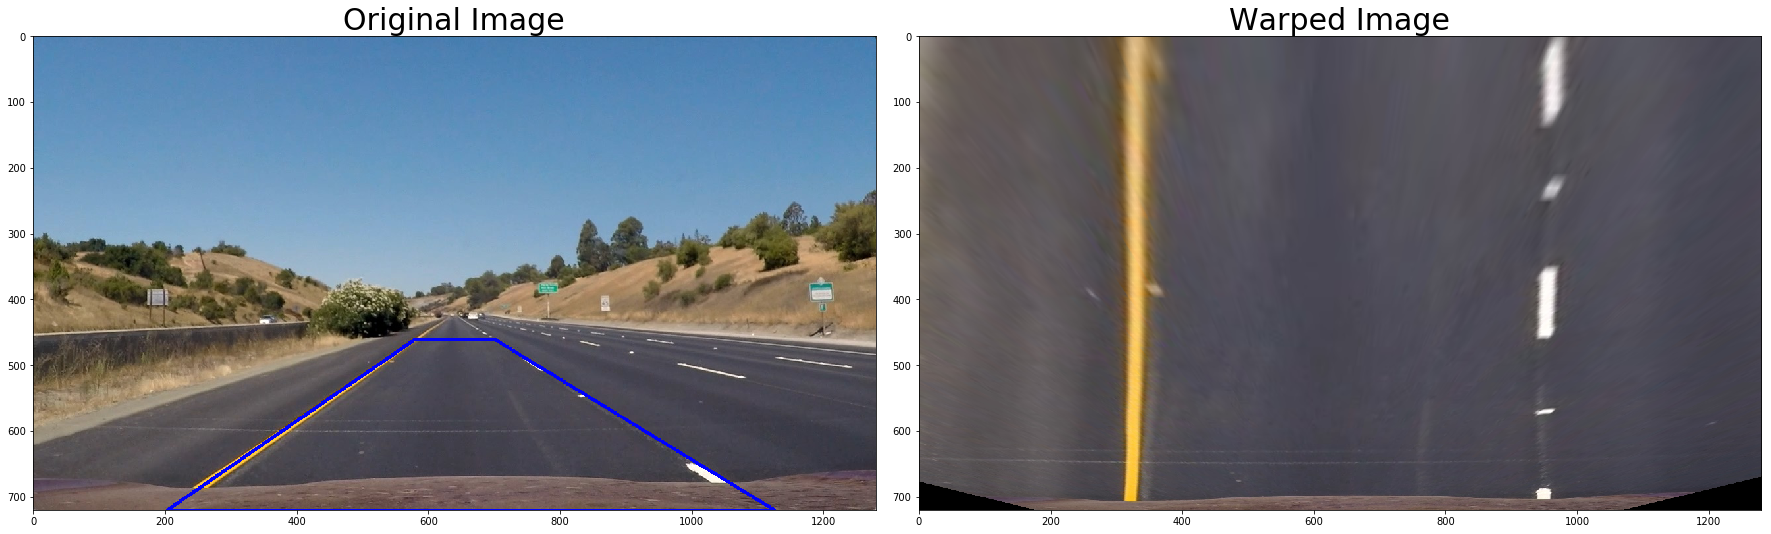

In [7]:
# step 3 percpective warping of the lanes binary mask.
M, Minv = set_percpective_transform(img=cv2.imread('test_images/straight_lines1.jpg'), draw_intermidiate=True)

I have hard coded the warping area as a trapezoid over the lines in one of the straight line images. it seems to be working fine. we are saving a warp matrix (M) and an inverse warp matrix (Minv) so we can convert the images back if needed

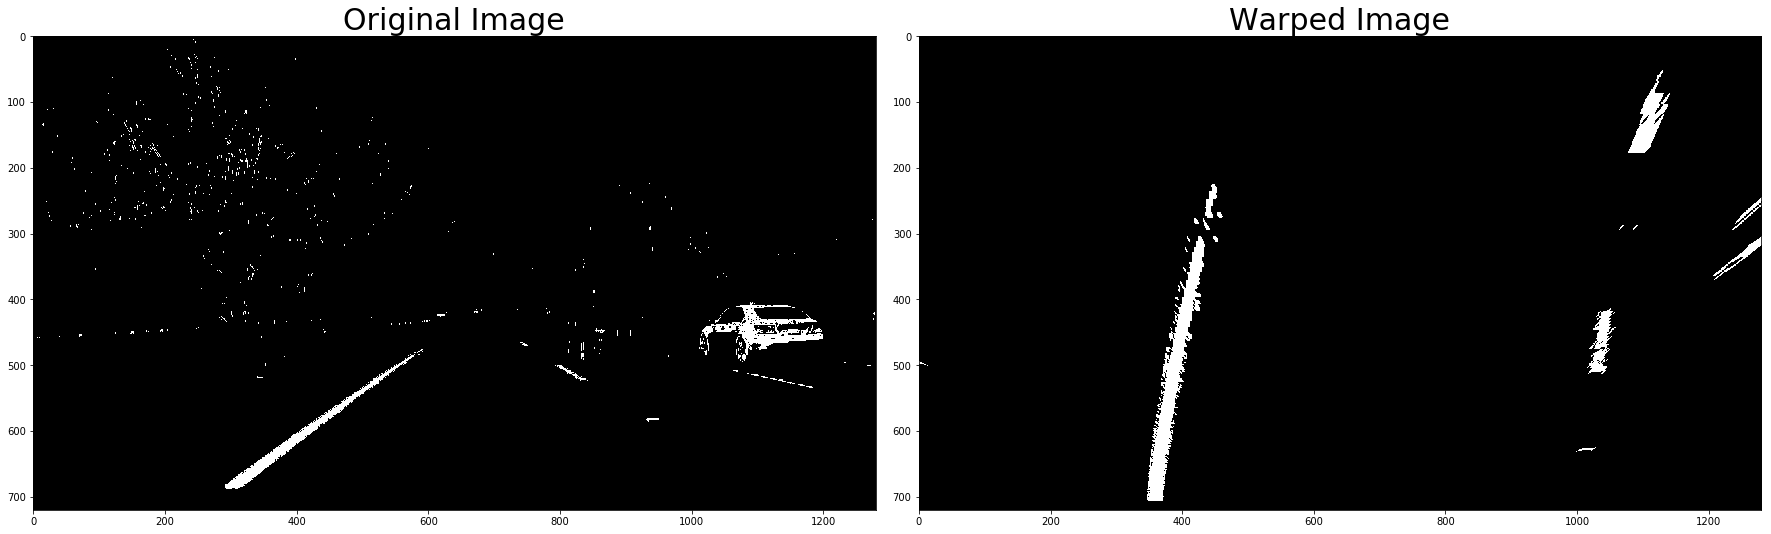

In [8]:
# back to the original image. here is its "eagle eye" view:
warped = warp_image(binary, M, draw_intermidiate=True)

In [9]:
warped = warped[100:,:] # mask the top part of the binary mask, i found that it tends to be too noisy

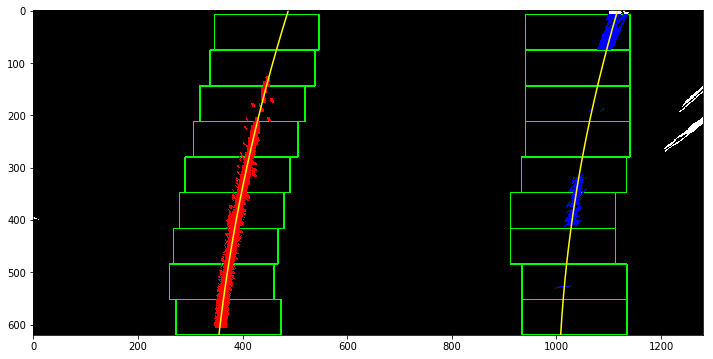

In [10]:
# Step 4: Calculate the the curvature of the lanes
left_fit, right_fit, left_fit_cr, right_fit_cr = curv_calc_sliding_window(warped, draw_intermidiate=True)

In order to do the fit we should first determine which pixels should be part of it. we can do it using a sliding window technique, that findes the center of the activated pixels histogram, and than follows the lane shape. as you can see, the white pixels are not effecting the curvature calculation.

alternatively, if a previous curve was already calculated, we can you it as a mask for faster calculation speed (and maybe even add a bit of robustness to the algorithm)

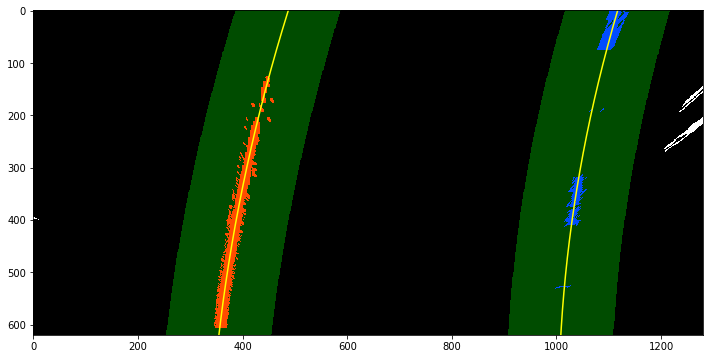

In [11]:
left_fit, right_fit, left_fit_cr, right_fit_cr = curv_calc_from_previous(warped, left_fit, right_fit, draw_intermidiate=True)

Please note - the left_fit, right_fit are in pixel units, and the left_fit_cr, right_fit_cr are in meters.

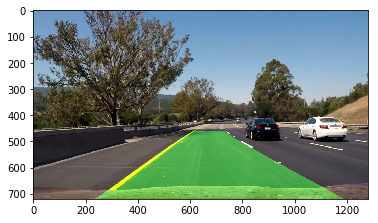

In [12]:
# Step 5: Draw the lines back on the original image
lines_img = add_lines_to_img(img, left_fit, right_fit, Minv, draw_intermidiate=True)

we are using the calculated curvature fit that we have calculated on the "eagle eye" perspective and we are using the inverse warp matrix in order to put them back on the original image

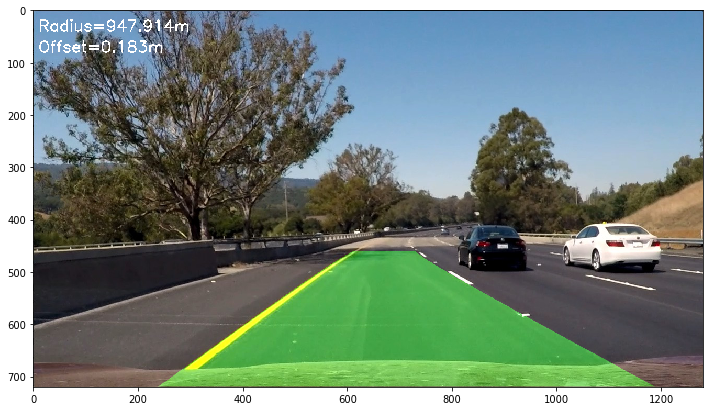

In [13]:
# Step 6: Calculate curvature and offset
out = measure_curvature_and_offset(lines_img, left_fit_cr, right_fit_cr, draw_intermidiate=True)

We are calculating the curvature from the curvature equations that were calculated in meters, the offset is calculated according to the distance of the lanes middle from the image center at the bottom of the screen.

In [14]:
# So this is the single image pipline:


def single_image_pipeline(img):
    global cal_values, M, Minv
    # step1 - undistort the image
    img = cv2.undistort(img, cal_values['mtx'], cal_values['dist'], None, cal_values['mtx'])
    # step2 - turn into binary image using color and gradient thresholds
    binary = color_and_grad_binary(img, s_thresh=(150,255), l_thresh=(50,255), sx_thresh=(100,255))
    # step3 - use perspective warping to look at the image from eagle eye view
    warped = warp_image(binary, M)
    warped = warped[100:,:] # mask the top part of the binary mask
    # step4 - find the pixels of the lanes and fit a polynom for them. we don't have previous info, since this is a single image
    left_fit, right_fit, left_fit_cr, right_fit_cr = curv_calc_sliding_window(warped)
    # step5 - unwarp the lines and draw them back on the original image
    lines_img = add_lines_to_img(img, left_fit, right_fit, Minv)
    # step6 - caculate the offset and curvature in real world units ([m])
    out = measure_curvature_and_offset(lines_img, left_fit_cr, right_fit_cr)
    return out

Text(0.5,1,'After Pipeline')

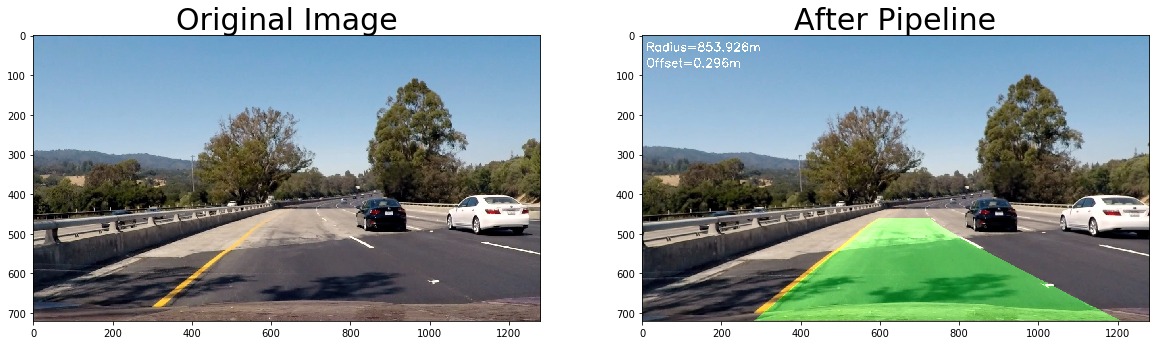

In [15]:
# run the pipeline on another image
img = images[5]
out = single_image_pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
ax2.set_title('After Pipeline', fontsize=30)

Yey!

## Part 3 - Use pipeline in a video

In [16]:
# When analyzing a video we can use the information of previous frames and use it to smooth out the outputs
# we can create a Line class that will keep track of this info
class Line():
    def __init__(self):
        # x values of the last n fits of the line
        self.recent_fits = [] 
        self.recent_fits_cr = []
        self.last_output = [None]
        self.last_output_cr = [None]
 
    def process_line(self, fit, fit_cr):
        '''
        gets new line parameters, compares them to what was previously calculated and sends back updated lines accordingally
        '''
        if fit[0] == None:
            # if the algo didn't find any fit. we assume that is is a bad frame, and return the last value we have seen
            return self.last_output, self.last_output_cr
        
        if len(self.recent_fits) < 3:
            # if we don't have significant history, we just return the line as it is
            self.recent_fits.append(fit)
            self.recent_fits_cr.append(fit_cr)
            self.last_output, self.last_output_cr = fit, fit_cr
            return fit, fit_cr
        
        # calculate average of previous lines
        prev_fit_avg = np.mean(self.recent_fits, axis=0)
        prev_fit_cr_avg = np.mean(self.recent_fits_cr, axis=0)
        
        # calculate the L1 distace between the previous fits average and current line
        # if the difference is too big, we will restart the lane history
        # this scale should balance the effects of the weights
        scale = np.array([1e4,1e1,1e-2]) 
        l1_dist = np.sum(np.abs(fit*scale - prev_fit_avg*scale))
        if l1_dist > 10: # found this TH after some experimentation with the test images            
            self.recent_fits = [fit] 
            self.recent_fits_cr = [fit_cr]
            self.last_output = fit
            self.last_output_cr = fit_cr
            return self.last_output, self.last_output_cr
            
        # smooth the output line, with previous linesaverage
        out_fit = 0.6 * fit + 0.4 * prev_fit_avg
        out_fit_cr = 0.6 * fit_cr + 0.4 * prev_fit_cr_avg
        
        # updated the fit history
        self.recent_fits.append(fit)
        self.recent_fits_cr.append(fit_cr)
        self.last_output, self.last_output_cr = fit, fit_cr
        
        # we keep only the last line fits for our calculations
        if len(self.recent_fits) > 6:
            self.recent_fits.pop(0)
        
        return out_fit, out_fit_cr
         

In [17]:
# new pipeline for videos:

# first we initialize the line objects
left_line = Line()
right_line = Line()

first_frame = True
left_fit = [None] # added as a safty condition for failures on previous frames

def video_frame_pipeline(img):
    global cal_values, M, Minv, left_line, right_line, first_frame, left_fit
    # step1 - undistort the image
    img = cv2.undistort(img, cal_values['mtx'], cal_values['dist'], None, cal_values['mtx'])
    
    # step2 - turn into binary image using color and gradient thresholds
    binary = color_and_grad_binary(img, s_thresh=(150,255), l_thresh=(50,255), sx_thresh=(100,255))
    
    # step3 - use perspective warping to look at the image from eagle eye view
    warped = warp_image(binary, M)
    warped = warped[100:,:] # mask the top part of the binary mask
    # step4 - find the pixels of the lanes and fit a polynom for them
    if first_frame:
        left_fit, right_fit, left_fit_cr, right_fit_cr = curv_calc_sliding_window(warped)
        first_frame = False
    else:
        prev_left_fit = left_line.last_output
        prev_right_fit = right_line.last_output
        if left_fit[0] == None:
            # if the previous fit did not find a line, we try to recalculate it with sliding window
            left_fit, right_fit, left_fit_cr, right_fit_cr = curv_calc_sliding_window(warped)
        try:
            left_fit, right_fit, left_fit_cr, right_fit_cr = curv_calc_from_previous(warped, prev_left_fit, prev_right_fit)
        except:
            pass
        if left_fit[0] == None:
            # if the current fit did not find a line, we try to recalculate it with sliding window
            left_fit, right_fit, left_fit_cr, right_fit_cr = curv_calc_sliding_window(warped)
        
    # step5 - process the lines by comparing them to the line history
    left_fit, left_fit_cr = left_line.process_line(left_fit, left_fit_cr)
    right_fit, right_fit_cr = right_line.process_line(right_fit, right_fit_cr)
    
    if left_fit[0] == None or right_fit[0] == None:
        return img # if after everything, we still failed to find a line, we return the original image...
    
    # step6 - unwarp the lines and draw them back on the original image
    lines_img = add_lines_to_img(img, left_fit, right_fit, Minv)
    
    # step7 - caculate the offset and curvature in real world units ([m])
    out = measure_curvature_and_offset(lines_img, left_fit_cr, right_fit_cr)
    return out

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
# first we initialize the line objects
left_line, right_line = Line(), Line()
first_frame = True
left_fit = [None]

video_output = 'output_images/projectVideo.mp4'

clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(video_frame_pipeline)
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/projectVideo.mp4
[MoviePy] Writing video output_images/projectVideo.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:23<00:00, 15.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/projectVideo.mp4 

Wall time: 1min 24s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

# Awsome!
technically we are done. let's see how we a dealing with the more challenging cases

In [21]:
left_line, right_line = Line(), Line()
first_frame = True

video_output = 'output_images/challenge_video.mp4'

clip1 = VideoFileClip("challenge_video.mp4")
project_clip = clip1.fl_image(video_frame_pipeline)
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:29<00:00, 16.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

Wall time: 30.5 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

absolute failure :) it seems like the black lines on the road really ruind my pipeline. i probably need to try a diffrent approach for the binary mask... i need to retune my thresholds by using frames from taken from this video probably..